In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Used to clacc the Shannon Diversity of many datasets.
# dataset_list = ["ENZYMES", "PROTEINS", "IMDB-Binary", "IMDB-Multi", "NCI1"]

# data = []
# for dataset_name in dataset_list:
#     dataset = torch_geometric.datasets.TUDataset(root=f"Code/datasets", name=dataset_name).shuffle()
#     unbalance = utils.calc_shannon_diversity(dataset)
#     data.append([dataset_name, unbalance])

# run = wandb.init(
#     project="BachelorThesisExperiments",
#     name="ShannonDiversity")

# table = wandb.Table(data=data, columns=["Dataset", "Shannon Diversity"])
# wandb.log({"Shannon Diversity": table})
# wandb.finish()

In [3]:
unbalances = pd.read_csv("results/wandb_unbalances.csv")
unbalances.pivot_table(columns="Dataset", values="Shannon Diversity")

Dataset,ENZYMES,IMDB-Binary,IMDB-Multi,NCI1,PROTEINS
Shannon Diversity,1.0,1.0,1.0,1.0,0.973


In [4]:
accuracies = pd.read_csv("results/wandb_accuracies.csv")
pivot_table = accuracies.pivot(index="k_wl", columns="Dataset", values="Max Accuracy")
pivot_table.style.highlight_max(color = 'lightgreen', axis = 0)

Dataset,ENZYMES,IMDB-Binary,IMDB-Multi,NCI1,PROTEINS
k_wl,,,,,
0,0.813333,0.606000,0.441333,0.913382,0.919137
1,1.000000,0.886000,0.632667,0.995377,0.997305
2,1.000000,0.886000,0.632667,0.998054,0.997305
3,1.000000,0.886000,0.632667,0.998297,0.997305
4,1.000000,0.886000,0.632667,0.998297,0.997305
5,1.000000,0.886000,0.632667,0.998297,0.997305


In [57]:
def calc_svm_boundary_contour(X, Y, clf, n_points=100):
    """
    Calculate the decision boundary contour of a trained SVM classifier.

    Args:
        X: Numpy array of shape (n_samples, 2) containing the samples.
        Y: Numpy array of shape (n_samples,) containing the labels.
        clf: Trained SVM classifier.
        n_points: Number of points to use for the contour.

    Returns:
        Tuple (xx, yy, Z) where xx and yy are numpy arrays of shape (n_points, n_points) containing the x and y
        coordinates of the contour points and Z is a numpy array of shape (n_points, n_points) containing the
        corresponding decision values.
    """
    # Create a grid of points
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h_x0 = (x0_max - x0_min) / n_points
    h_x1 = (x1_max - x1_min) / n_points
    xx, yy = np.meshgrid(np.arange(x0_min, x0_max, h_x0), np.arange(x1_min, x1_max, h_x1))

    # Calculate the decision values for the grid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    dataframe = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel(), Z.ravel()], columns=["x", "y", "prediction"])
    return dataframe

def plot_aggegrate(aggregates, **kwargs):
    X = aggregates[['x', 'y']].to_numpy()
    Y = aggregates['class'].to_numpy()

    clf = SVC(kernel = 'rbf',  gamma='scale', C=1.0)
    clf.fit(X, Y)

    svm_data = calc_svm_boundary_contour(X, Y, clf, **kwargs)

    sns.kdeplot(data=svm_data, x="x", y="y", hue="prediction", levels=5, alpha=0.5, fill=True, thresh=0.1)
    sns.scatterplot(data=aggregates, x="x", y="y", hue="class")
    plt.show()

In [53]:
#aggregates = pd.read_csv("/Users/ericbill/Downloads/wandb_export_2023-06-06T09_05_22.509+02_00.csv")
aggregates = pd.read_csv("/Users/ericbill/Downloads/wandb_export_2023-06-06T10_09_30.892+02_00.csv")
#aggregates = pd.read_csv("/Users/ericbill/Downloads/wandb_export_2023-06-06T09_24_06.338+02_00.csv")
aggregates

,x,y,class
0,-36.999428,8.471334,1
1,42.820229,-5.592344,0
2,-18.005522,-3.604877,1
3,21.787542,-18.089804,0
4,23.768675,5.178766,0
...,...,...,...
1108,29.146761,-12.002493,0
1109,17.345890,21.998837,0
1110,10.972872,-19.112568,0
1111,12.574415,15.388547,0


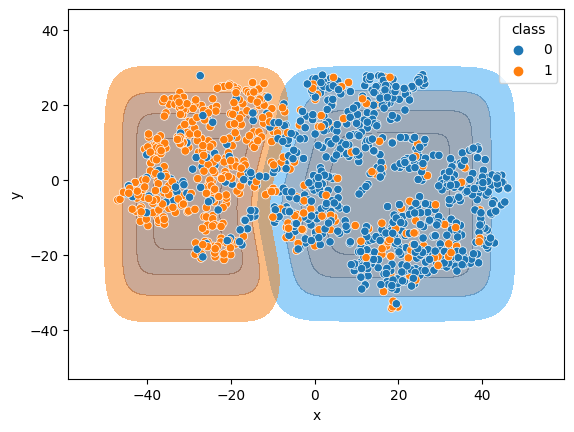

In [60]:
plot_aggegrate(aggregates, n_points=50)